# EG01-EG30Transition Scenario
The following jupyter notebook demonstrates the usage of CYCLUS to run
an EG01 to EG30 transition scenario. 

* This is a simplified version, where isotopes are separated into 4 groups (U, TRU, MA, FP), represented by U238, Pu239, Am241, and Cs137


### Import Necessary Module and Set Path 
Necessary modules for analysis are imported

In [19]:
import sqlite3 as lite
import os
import sys
import collections
from pyne import nucname
sys.path.insert(0, '../scripts/')
jupyter_directory = os.getcwd()

### The analysis.py file is a simple sqlite query and plotting script to analyze and visualize cyclus SQL output files. The script can be found in [https://github.com/arfc/transition-scenarios](https://github.com/arfc/transition-scenarios)

In [20]:
import analysis as an

## Run Cyclus Input file

In [21]:
# Removes previous cyclus output file, just in case.
! rm cyclus.sqlite

# runs xml input file.
! cyclus eg01-eg30-simple.xml

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

## Wait for the Complete Message...

### The output file should be named 
         
          cyclus.sqlite

### The analysis.py works mostly like such:
    1. function returns a dictionary of timeseries (massflow, installed power, etc)
    2. plotting function (stacked_bar or line_plot) creates plots out of the dictionary
    3. png file is saved in the directory of the notebook file.

In [22]:
# define filename to create sqlite cursor for analysis
filename = 'cyclus.sqlite'

# get sqlite cursor using a function in analysis.py
cur = an.get_cursor(filename)

# get simulation time info
init_year, init_month, duration, timestep = an.get_timesteps(cur)

# outputs net capacity and number of reactor timeseries plot
an.plot_power(cur)


# prints maximum required sfr fuel throughput per timestep
sfr_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                       'INNER JOIN resources ON resources.resourceid = '
                       'transactions.resourceid WHERE commodity = "sfr_fuel"'
                       ' GROUP BY time').fetchall()
print(max(an.get_timeseries(sfr_fuel, duration, True)))

# prints maximum required mox fuel throughput per timestep
mox = cur.execute('SELECT time, sum(quantity) FROM transactions '
                       'INNER JOIN resources ON resources.resourceid = '
                       'transactions.resourceid WHERE commodity = "mox"'
                       ' GROUP BY time').fetchall()
print(max(an.get_timeseries(mox, duration, True)))


# get fuel mass timeseries
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox', 'sfr_fuel'])
an.stacked_bar_chart(fuel_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'Total Fuel Mass vs Time',
                  'total_fuel',
                  init_year)


# output plot of ratio of SFRs over MOX_LWRs.
power_dict = an.get_power_dict(cur)
ratio = {}
ratio['fr_to_lwr_ratio'] =[x/y for x, y in zip(power_dict['fr_inst'], power_dict['mox_lwr_inst'])]
an.stacked_bar_chart(ratio, timestep, 'Year', 'FR capacity / LWR capacity',
                     'Ratio vs Time', 'ratio', init_year)


# get tailings mass timeseries
agent_ids = an.get_agent_ids(cur, 'enrichment')
tailings = an.facility_commodity_flux(cur, agent_ids,
                                      ['tailings'], True)
an.stacked_bar_chart(tailings, timestep,
                  'Year', 'Mass [MTHM]',
                  'Tailings vs Time',
                  'tailings', init_year)

# natural uranium demand
nat_u = collections.OrderedDict()
nat_u['nat_u'] = an.nat_u_timeseries(cur)
an.stacked_bar_chart(nat_u, timestep,
                     'Years', 'Natural Uranium Mass',
                     'Natural Uranium Demand vs Time',
                     'nat_u', init_year)

# uranium utilization
dictionary = {}
dictionary['uranium_utilization'] = an.u_util_calc(cur)
an.stacked_bar_chart(dictionary, timestep,
                     'Years', 'U Utilization Factor',
                     'U Utilization vs Time',
                     'u_util', init_year)

# get reprocessed material flow
agent_ids = an.get_agent_ids(cur, 'separations')
combined = an.facility_commodity_flux(cur, agent_ids, ['mox_TRU', 'uox_TRU', 'sfr_TRU'], True)
uox_TRU = an.facility_commodity_flux(cur, agent_ids, ['uox_TRU'], True)
mox_TRU = an.facility_commodity_flux(cur, agent_ids, ['mox_TRU'], True)
sfr_TRU = an.facility_commodity_flux(cur, agent_ids, ['sfr_TRU'], True)
an.stacked_bar_chart(combined, timestep, 'Years', 'Mass[MTHM]',
                  'Total reprocessed outflux vs Time', 'combined',
                  init_year)
an.stacked_bar_chart(uox_TRU, timestep, 'Years', 'Mass[MTHM]',
                  'reprocessed from spent UOX vs Time', 'from_spent_uox',
                  init_year)
an.stacked_bar_chart(mox_TRU, timestep, 'Years', 'Mass[MTHM]',
                  'reprocessed from spent MOX vs Time', 'from_spent_mox',
                  init_year)
an.stacked_bar_chart(sfr_TRU, timestep, 'Years', 'Mass[MTHM]',
                  'reprocessed from spent SFR Fuel vs Time', 'from_spent_sfr',
                  init_year)
print('Finished!')

sink_source_facilities has no values
sink_source_facilities has no values
2588.043
662.3


/home/dkadkf/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in double_scalars


The Average Fuel Utilization Factor is: 
0.133628956424
Finished!


## The Benefits of using a jupyter notebook is that one can run sqlite queries if a question rises.

In [23]:
# Like such:

# Number of Reactors Deployed
cur = an.get_cursor(filename)

# Number of LWRs deployed
lwr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "lwr"').fetchone()
print('The Number of LWRs Deployed:')
print(lwr[0])

# Number of MOX LWRs deployed
mox_lwr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "mox_lwr"').fetchone()
print('The Number of MOX LWRs Deployed:')
print(mox_lwr[0])

# Number of SFRs deployed
sfr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "fr"').fetchone()
print('The Number of FRs Deployed:')
print(sfr[0])

The Number of LWRs Deployed:
305
The Number of MOX LWRs Deployed:
112
The Number of FRs Deployed:
2038


In [24]:
# Fresh and Spent Fuel Composition
cur = an.get_cursor(filename)

sfr_fuel_qualid = cur.execute('SELECT qualid FROM transactions '
                              'INNER JOIN resources ON '
                              'resources.resourceid = transactions.resourceid '
                              'WHERE commodity = "sfr_fuel"').fetchone()
fresh_sfr_mox_comp = cur.execute('SELECT nucid, massfrac FROM compositions '
                                 'WHERE qualid = ' + str(sfr_fuel_qualid[0])).fetchall()
print('Composition for fresh sfr fuel: ')
for isotope in fresh_sfr_mox_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')

print('\n \n')

sfr_waste_comp = cur.execute('SELECT nucid, massfrac FROM recipes '
                             'LEFT OUTER JOIN compositions '
                             'ON recipes.qualid = compositions.qualid '
                             'WHERE recipe = "sfr_waste_recipe"').fetchall()
print('Composition for sfr spent fuel: ')
for isotope in sfr_waste_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')
    


mox_fuel_qualid = cur.execute('SELECT qualid FROM transactions '
                              'INNER JOIN resources ON '
                              'resources.resourceid = transactions.resourceid '
                              'WHERE commodity = "mox"').fetchone()
fresh_mox_comp = cur.execute('SELECT nucid, massfrac FROM compositions '
                             'WHERE qualid = ' + str(sfr_fuel_qualid[0])).fetchall()
print('Composition for fresh mox fuel: ')
for isotope in fresh_mox_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')


mox_waste_comp = cur.execute('SELECT nucid, massfrac FROM recipes '
                             'LEFT OUTER JOIN compositions '
                             'ON recipes.qualid = compositions.qualid '
                             'WHERE recipe = "mox_waste_recipe"').fetchall()
print('Composition for mox spent fuel: ')
for isotope in mox_waste_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')

Composition for fresh sfr fuel: 
U232: 9.475748133052818e-08 %
U233: 2.0978372873322628e-07 %
U234: 0.016288090883859678 %
U235: 0.7247677287263131 %
U236: 0.5406621295474839 %
U238: 87.25828174630115 %
Np237: 0.5421601728431595 %
Pu238: 0.25942165566054237 %
Pu239: 5.39846286569208 %
Pu240: 2.586207234385957 %
Pu241: 1.5645397011796784 %
Pu242: 0.7688315655022873 %
Pu244: 2.549719103062644e-05 %
Am241: 0.057339756303778716 %
Am242M: 0.0007594870096173333 %
Am243: 0.17656696035322947 %
Cm242: 0.023049816673410977 %
Cm243: 0.0006861853067693523 %
Cm244: 0.0761978881690134 %
Cm245: 0.005092318571631569 %
Cm246: 0.0006493106658270519 %
Cm247: 8.899939128007164e-06 %
Cm248: 6.845528565709542e-07 %
Cm250: 3.809894408450669e-15 %

 

Composition for sfr spent fuel: 
Cs137: 6.657910689028086 %
U238: 81.02646999393816 %
Pu239: 11.49727217619721 %
Am241: 0.8183471408365326 %
Composition for fresh mox fuel: 
U232: 9.475748133052818e-08 %
U233: 2.0978372873322628e-07 %
U234: 0.016288090883859678 

## Simulation Restuls
This cell outputs a  file that contains all the metrics for this transition scenario.

In [25]:
outstring = ''
outstring += 'Initial Year:' + str(init_year) + '\n'
outstring += 'Initial Month:' + str(init_month) + '\n'
outstring += 'Duration in Months:' + str(duration) + '\n'
outstring += 'End Year:' + str(int(init_year + duration/12)) + '\n'

outstring += '\n'

outstring += 'Total Fuel Used: [MTHM]' + '\n'
first = True
for key in fuel_dict:
    outstring += '\t' + key + ': ' + str(max(fuel_dict[key])) + '\n'
    if first:
        total = fuel_dict[key]
        first = False
    else:
        total = [x + y for x, y in zip(total, fuel_dict[key])]
outstring += '\t' + key + ': ' + str(max(total)) + '\n'

outstring += '\n'

outstring += 'Total Natural Uranium [MTHM]' + '\n'
outstring += '\t' + str(max(nat_u['nat_u'])) + '\n'

outstring += 'Total Tailings [MTHM]' + '\n'
outstring += '\t' + str(max(tailings['tailings'])) + '\n'

outstring += '\n'

outstring += 'Average Fuel Utilization Factor (Fuel/NatU):' + '\n'
outstring += '\t' + str(sum(dictionary['uranium_utilization']) / len(dictionary['uranium_utilization'])) + '\n'

outstring += '\n'

outstring += 'TRU reprocessed: [MTHM]' + '\n'
first = True
for key in combined:
    outstring += '\t' + key + ': ' + str(max(combined[key])) + '\n'
    if first:
        total = combined[key]
        first = False
    else:
        total = [x + y for x, y in zip(total, combined[key])]
outstring += '\t Total: ' + str(max(total)) + '\n'

outstring += '\n' 

outstring += 'Reactors Deployed:' + '\n'
outstring += '\t LWR: ' + str(lwr[0]) + '\n'
outstring += '\t FR: ' + str(sfr[0]) + '\n'
outstring += '\t MOX_LWR: ' + str(mox_lwr[0]) + '\n'

outstring += '\n'

outstring += 'Compositions' + '\n'
outstring += '\t Composition for fresh sfr fuel: ' + '\n'
for isotope in fresh_sfr_mox_comp:
    outstring += '\t\t ' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' + '\n'
    
outstring += '\t Composition for fresh sfr spent fuel: ' + '\n'
for isotope in sfr_waste_comp:
    outstring += '\t\t' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' + '\n'

outstring += 'Composition for fresh mox fuel: '
for isotope in fresh_mox_comp:
    outstring += '\t\t' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' +'\n'
    
outstring += 'Composition for mox spent fuel: '
for isotope in mox_waste_comp:
    outstring +=  '\t\t' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' + '\n'
    
print(outstring)
if 'simulation_results':
    with open('simulation_results', 'w') as output:
        output.write(outstring)

Initial Year:1959
Initial Month:1
Duration in Months:3024
End Year:2211

Total Fuel Used: [MTHM]
	uox: 486663.49
	mox: 116697.26
	sfr_fuel: 494668.239
	sfr_fuel: 1098028.989

Total Natural Uranium [MTHM]
	4343853.897
Total Tailings [MTHM]
	3857190.407

Average Fuel Utilization Factor (Fuel/NatU):
	0.133628956424

TRU reprocessed: [MTHM]
	mox_TRU: 8434.784831
	uox_TRU: 6135.98604014
	sfr_TRU: 54445.9635364
	 Total: 69016.7344076

Reactors Deployed:
	 LWR: 305
	 FR: 2038
	 MOX_LWR: 112

Compositions
	 Composition for fresh sfr fuel: 
		 U232: 9.475748133052818e-08 %
		 U233: 2.0978372873322628e-07 %
		 U234: 0.016288090883859678 %
		 U235: 0.7247677287263131 %
		 U236: 0.5406621295474839 %
		 U238: 87.25828174630115 %
		 Np237: 0.5421601728431595 %
		 Pu238: 0.25942165566054237 %
		 Pu239: 5.39846286569208 %
		 Pu240: 2.586207234385957 %
		 Pu241: 1.5645397011796784 %
		 Pu242: 0.7688315655022873 %
		 Pu244: 2.549719103062644e-05 %
		 Am241: 0.057339756303778716 %
		 Am242M: 0.0007594870

### Plots
Plots can be viewed inside the notebook, but also on your local directory.

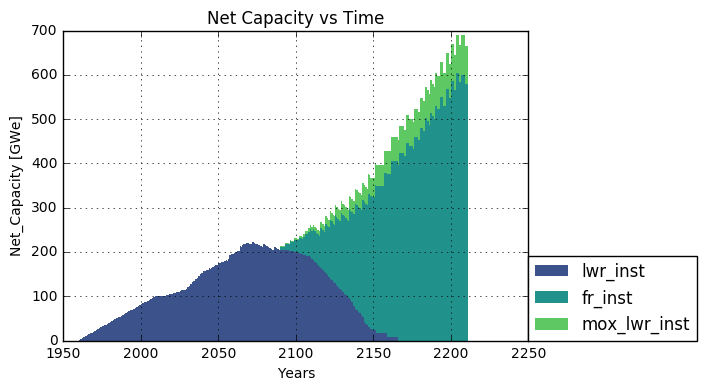

In [26]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')


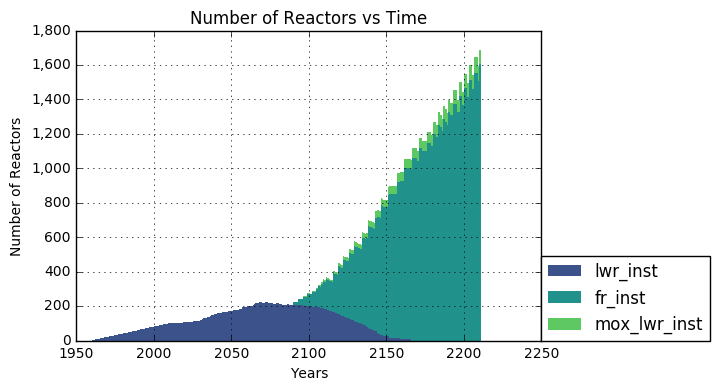

In [27]:

# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='num_plot.png')


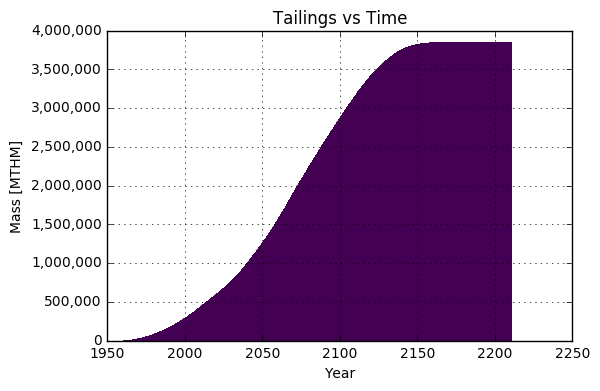

In [28]:

# Display Tailings vs Time
from IPython.display import Image
Image(filename='tailings.png')


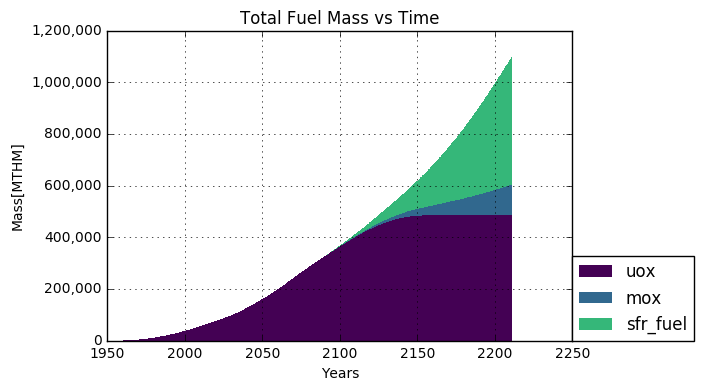

In [29]:

# Display Total Fuel vs Time
from IPython.display import Image
Image(filename='total_fuel.png')


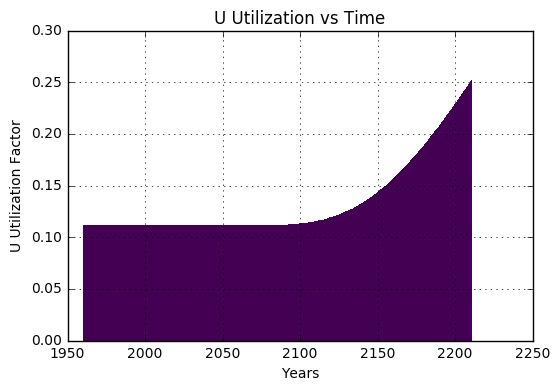

In [30]:

# Display Uranium Utilization vs Time
from IPython.display import Image
Image(filename='u_util.png')


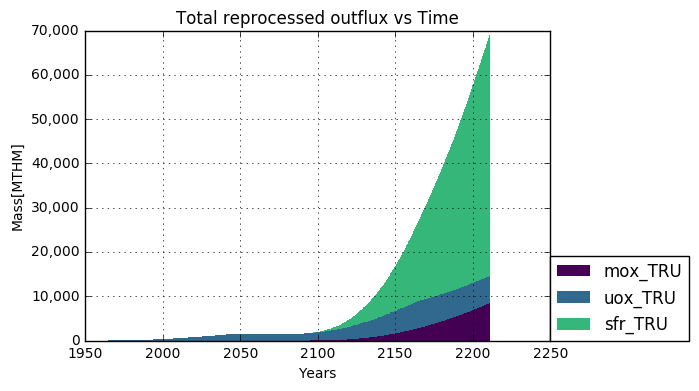

In [31]:

# Display Separated Pu Flow
from IPython.display import Image
Image(filename='combined.png')


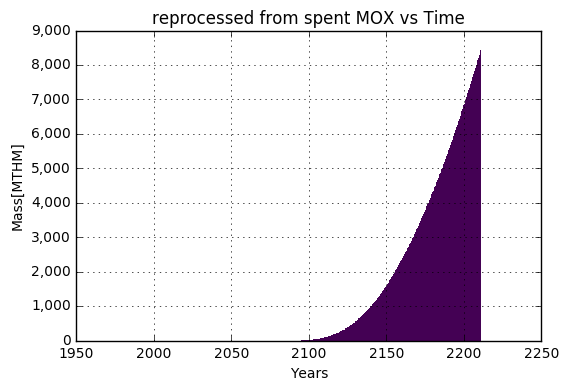

In [32]:

from IPython.display import Image
Image(filename='from_spent_mox.png')


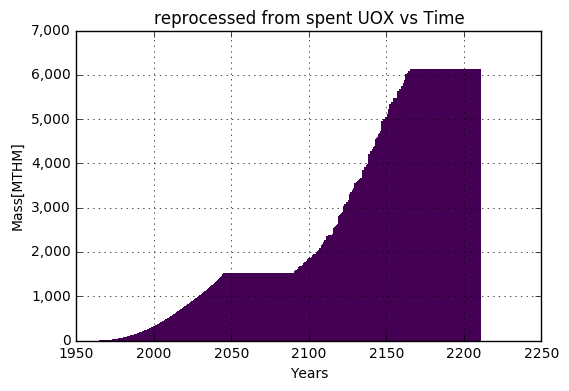

In [33]:

from IPython.display import Image
Image(filename='from_spent_uox.png')

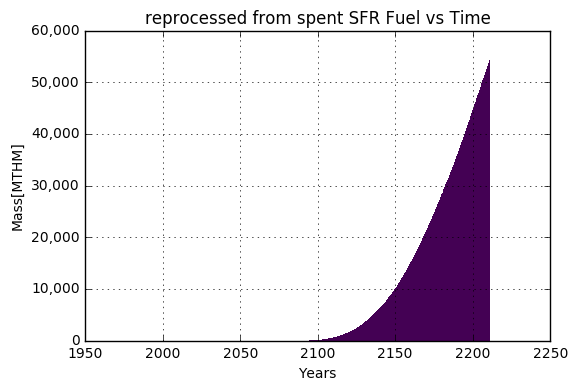

In [34]:

from IPython.display import Image
Image(filename='from_spent_sfr.png')